## Requirements:
1) Use a conda distribution with numpy, scipy, matplotlib and pandas. If not, install with pip. 

2) Install cvxpy using: 

    pip install cvxpy
    
3) You can test the installation with nose:
    
    pip install nose
    
    nosetests cvxpy

In [1]:
%run -i 'src/SPV.py'
from src.data_functions import *
from src.solution_algorithms import *

## Load Generation, Demand and Prices Data
Download the csv files from:

https://www.dropbox.com/s/o0qcyalnnhbeqsu/full_randomized_2017_hourly_normalized_v2.csv?dl=0

https://www.dropbox.com/s/1qkkg6s4yndnohm/LMP_2017_data.csv?dl=0

Add the csv files to data folder

In [71]:
df = pd.read_csv('data/full_randomized_2017_hourly_normalized_v2.csv') #Load demand and solar generation per kW dataframe
df2 = pd.read_csv('data/LMP_2017_data.csv') #Load wholesale prices data for CAISO
df3 = pd.read_csv('data/LMP_2017_hourly_ERCOT.csv') #Load wholesale prices data for ERCOT

In [88]:
df3['sced_timestamp'] = pd.to_datetime(df3['sced_timestamp'])
df3.groupby(df3['sced_timestamp'].index.hour).mean()

AttributeError: 'RangeIndex' object has no attribute 'hour'

## Obtain lists, matrices and arrays from dataframes

In [72]:
dataids = obtain_dataid_2017(df) #list of dataids of firms
dataids_array = np.asarray(dataids) #numpy array of dataids 
validdata = len(dataids) #Total of firms
T = len(df[df.dataid==26].use.values) #Total of time slots
localtime_data = df[df.dataid==26].localhour #Hour data of time slots

In [73]:
gen_kw = f_gen_per_kw(df) #Matrix of normalized solar generation: Rows are timeslots and columns are firms
load_kw = f_load_kw(df) #Matrix of load: Rows are timeslots and columns are firms

1 m$^2$ is 1550 in$^2$

Typical size of solar panel: is 65 in for 39 in = 2535 in$^2$ = 1.6354 m$^2$.

The rated power of a solar panel is typically between 250 to 350W.

To convert we use: gen_per_kw by 0.3 / 1.6354 to get gen_per_m$^2$.

In [74]:
gen_per_m2 = gen_kw*0.3/1.6354

In [75]:
#Investment per m2 is 512.2 $/m2.
#Using an anualized cost with discount rate r=5%, we obtain
CostPVperM2 = 512.2
r = 0.05
years = 20
annuity = CostPVperM2*r/(1-(1+r)**(-years)) #Obtain Annuity 
pi_s = annuity/T #Obtain cost per time step
print('Cost of PV per time step: ' + str(pi_s) + ' in $/m2')

Cost of PV per time step: 0.004695025492240356 in $/m2


In [76]:
firms = validdata #Number of firms
gamma = 1 #Factor of NM price
pi_r = 0.18   #Retail Price at 18 cents per kWh.
pi_nm = gamma*pi_r  #Net Metering Price
a_cap_firms = f_cap_firms(gen_per_m2, load_kw) #Cap for firms to not be net producers

In [77]:
pi_g = f_lmp_prices(df2) #Obtain wholesale market prices for CAISO: Data is in $/MWh
pi_g = pi_g/1000 # convert to $/kWh
pi_g_ercot = df3.hb_busavg.values #Obtain wholesale market prices for ERCOT: Data is in $/MWh
pi_g_ercot = pi_g_ercot/1000 # convert to $/kWh

In [89]:
print(np.mean(pi_g))
print(np.mean(pi_g_ercot))

0.03311974685286726
0.024139201418840985


## Run Case 1: Limited maximum panel area

In [9]:
a_max_firms = 0.2*a_cap_firms
pv_changes = []
#gamma = np.linspace(0,1,21)
gamma = [0.9]

#Run the sharing case (that is not affected by gamma)
soluc_sharing = solve_sharing_collective(gen_per_m2, load_kw, dataids_array, a_max_firms, pi_s, pi_r) #Obtain the set of firms that invest
sol_sharing = firms_investment_sharing(soluc_sharing, a_max_firms, firms) #Obtain the investment decision of all firms
clear_output() #Comment this line to check the intermediate steps of the algorithm

for g in gamma:
    pi_nm = g*pi_r
    %run -i 'src/Case_01.py'
    pv_changes.append(aux)
    clear_output()

Solving firm 111 (of 1000) with dataid 7741


KeyboardInterrupt: 

NameError: name 'aux' is not defined

In [ ]:
#Plot pv changes between standalone and sharing case
plt.plot(gamma, pv_changes)

In [ ]:
# pi_nm = 0.9*pi_r
# investment_standalone = solve_standalone(gen_per_m2, load_kw, dataids, a_max_firms, pi_s, pi_r, pi_nm) #Solve a particular case you are interested

In [ ]:
print('\n')
print('Investment decisions:')
print(investment_standalone) #Print investment decisions
print('\n')
print('Percentage of investment per firm (with respect to max_cap)')
print(1-(a_max_firms - investment_standalone)/a_max_firms) #Print percentage of investment of available max cap
print('\n Total Investment of PV in standalone case is '+ str(sum(investment_standalone)) + ' in m2 \n')

## Run Case 2: Effect of annual cap

In [ ]:
a_max_firms = 1.5*a_cap_firms
#gamma = np.linspace(0,1,21)
gamma = [0.9]

In [ ]:
## Run Sharing model
soluc_sharing = solve_sharing_collective(gen_per_m2, load_kw, dataids_array, a_max_firms, pi_s, pi_r) #Obtain the set of firms that invest
sol_sharing = firms_investment_sharing(soluc_sharing, a_max_firms, firms) #Obtain the investment decision of all firms
clear_output()

In [ ]:
# Run standalone models for each gamma
for g in gamma:
    pi_nm = g*pi_r
    investment_standalone = solve_standalone(gen_per_m2, load_kw, dataids, a_cap_firms, pi_s, pi_r, pi_nm)
    clear_output()

In [ ]:
print(np.sum(sol_sharing)) #Print total PV investment in Sharing Model
print(np.sum(investment_standalone)) #Print total PV investment in Standalone Model
print((-np.sum(investment_standalone)+np.sum(sol_sharing))/np.sum(sol_sharing) ) #Print increase (or decrease) of PV investment between models

In [ ]:
total_gen_per_m2 = np.sum(gen_per_m2, axis=0) #Obtain sum of gen per m2, per firm
sorted_dataids_maxgen = np.argsort(-total_gen_per_m2) #Sort firms from high total irradiance to low irradiance
#print(sol_sharing[sorted_dataids_maxgen])
#print('/n')
#print(investment_standalone[sorted_dataids_maxgen])
sharing_cumsum = np.cumsum(sol_sharing[sorted_dataids_maxgen]) #Compute cumulative sum of PV investment for sorted firms in sharing model
standalone_cumsum = np.cumsum(investment_standalone[sorted_dataids_maxgen]) #Compute cumuliative sum of PV investment for sorted firms in standalone model

In [ ]:
plt.plot(sharing_cumsum)

In [ ]:
plt.plot(standalone_cumsum)

In [ ]:
# Save data if you are interested to plot in other software
np.savetxt("sharing_cumsum.csv", sharing_cumsum, delimiter=",")
np.savetxt("standalone_cumsum.csv", standalone_cumsum, delimiter=",")

## Run Case 3: Effect of demand charge in wholesale market prices

In [79]:
a_max_firms = 2*a_cap_firms
#pi_s_array = np.linspace(0.01, 0.2, 50)*pi_s
pi_s_array = np.linspace(0.08, 0.2, 30)*pi_s
#pi_s_array = [0.0]

In [68]:
pi_g2 = pi_g
#pi_g2 = pi_g_ercot
#pi_s_array = np.asarray([0.15*pi_s])
sol_wholesale_list_dcharge = []
demand_charge = 10 #in $/kWp
# Solve with demand charge for different costs of solar
for pi_s2 in pi_s_array:
    soluc_wholesale = solve_wholesale_aggregator_demandcharge(gen_per_m2, load_kw, a_max_firms, pi_s2, pi_g2, demand_charge)
    sol_wholesale_list_dcharge.append(np.sum(soluc_wholesale))
    clear_output()
levelized_cost_array = (1-(1+r)**(-years))/r * pi_s_array*T #Obtain overnight cost of PV
plt.plot(levelized_cost_array, sol_wholesale_list_dcharge)

KeyboardInterrupt: 

In [23]:
np.sum(soluc_wholesale)
np.sum(a_max_firms)

122300.40004407859

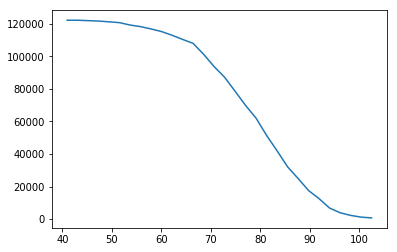

In [80]:
#pi_g2 = pi_g
pi_g2 = pi_g_ercot
sol_wholesale_list = []
# Solve without demand charge for different costs of solar
for pi_s2 in pi_s_array:
    soluc_wholesale_energy = solve_wholesale_aggregator(gen_per_m2, load_kw, a_max_firms, pi_s2, pi_g2)
    sol_wholesale_list.append(np.sum(soluc_wholesale_energy))
    clear_output()
levelized_cost_array = (1-(1+r)**(-years))/r * pi_s_array*T #Obtain overnight cost of PV
plt.plot(levelized_cost_array, sol_wholesale_list)

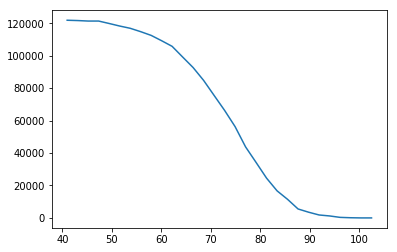

In [84]:
pi_g2 = pi_g
#pi_g2 = pi_g_ercot
sol_wholesale_list = []
# Solve without demand charge for different costs of solar
for pi_s2 in pi_s_array:
    soluc_wholesale_energy = solve_wholesale_aggregator(gen_per_m2, load_kw, a_max_firms, pi_s2, pi_g2)
    sol_wholesale_list.append(np.sum(soluc_wholesale_energy))
    clear_output()
levelized_cost_array = (1-(1+r)**(-years))/r * pi_s_array*T #Obtain overnight cost of PV
plt.plot(levelized_cost_array, sol_wholesale_list)

In [83]:
np.mean(pi_g)

0.03311974685286726

In [13]:
e_cost = wholesale_energy_costs(gen_per_m2,  load_kw, soluc_wholesale, pi_g) #Print energy costs for the collective with the solution of investment
print(e_cost)
e_cost = wholesale_energy_costs(gen_per_m2,  load_kw, 0, pi_g) #Print energy costs for the collective without investment in PV
print(e_cost)

40.869598279638275
46.49627836971733


In [14]:
d_cost = wholesale_demand_charge_costs(gen_per_m2, load_kw, soluc_wholesale, 10) #Print demand charge for the collective with the solution of investment
print(np.sum(d_cost))
zero_sol = np.zeros(validdata)
d_cost = wholesale_demand_charge_costs(gen_per_m2, load_kw, zero_sol, 10) #Print demand charge for the collective without investment in PV
print(np.sum(d_cost))

36.21559727498308
38.45957930610138


In [ ]:
tot_d_cost = np.sum(d_cost)
e_proportion = e_cost/(tot_d_cost+e_cost)*100
print(e_proportion) #Print proportion of energy costs with respect to total costs without PV investment

## Explore changes in profits for the Utility

In [ ]:
avg_profit_nopv = utility_profit_no_investment(load_kw, pi_r)

In [ ]:
avg_profit_standalone = utility_profit_standalone(gen_per_m2, load_kw, investment_standalone, pi_r, pi_nm)

In [ ]:
avg_profit_sharing = utility_profit_sharing(gen_per_m2, load_kw, sol_sharing, pi_r)

In [ ]:
pi_s_array = np.linspace(0.1, 0.2, 11)*pi_s
print(pi_s_array)

In [ ]:
np.sum(load_kw, axis=1).size

In [ ]:
aux = a_max_firms*gen_per_m2

In [ ]:
print(aux[10,1])
print(gen_per_m2[10,1])
print(a_max_firms[1]*gen_per_m2[10,1])

In [ ]:
df3 = df2.groupby(['OPR_HR']).mean()
print(df3)

In [ ]:
df4 = df2.mean()

In [ ]:
print(df4)

In [ ]:
A = np.array([[1,2],[3,4]])
b = np.array([[1,2]])
sol1 = np.dot(A,b.T)
sol2 = np.matmul(A,b.T)
print(sol1)
print(sol2)

In [ ]:
31+28+31

In [ ]:
localtime_data[24*334:]

In [ ]:
load_cost_matrix = (load_kw.T * pi_g).T

In [ ]:
load_cost_january = load_cost_matrix[0:24*31-1, :]

In [ ]:
load_cost_january.shape

In [ ]:
np.max([1,2,4])